## <center>Ensemble models from machine learning: an example of wave runup and coastal dune erosion</center>
### <center>Tomas Beuzen<sup>1</sup>, Evan B. Goldstein<sup>2</sup>, Kristen D. Splinter<sup>1</sup></center>
<center><sup>1</sup>Water Research Laboratory, School of Civil and Environmental Engineering, UNSW Sydney, NSW, Australia</center>

<center><sup>2</sup>Department of Geography, Environment, and Sustainability, University of North Carolina at Greensboro, Greensboro, NC, USA</center>


This notebook contains the code required to develop the Gaussian Process (GP) runup predictor developed in the manuscript "*Ensemble models from machine learning: an example of wave runup and coastal dune erosion*" by Beuzen et al.

**Citation:** Beuzen, T, Goldstein, E.B., Splinter, K.S. (In Review). Ensemble models from machine learning: an example of wave runup and coastal dune erosion, Natural Hazards and Earth Systems Science, SI Advances in computational modeling of geoprocesses and geohazards.

### Table of Contents:
1. [Imports](#bullet-0)
2. [Load and Visualize Data](#bullet-1)
3. [Develop GP Runup Predictor](#bullet-2)
4. [Test GP Runup Predictor](#bullet-3)
5. [Explore GP Prediction Uncertainty](#bullet-4)

## 1. Imports <a class="anchor" id="bullet-0"></a>

In [1]:
# Required imports
# Standard computing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gaussian Process tools
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Notebook functionality
%matplotlib inline

## 2. Load and Visualize Data <a class="anchor" id="bullet-1"></a>
In this section, we will load and visualise the wave, beach slope, and runup data we will use to develop the Gaussian process (GP) runup predictor.

In [2]:
# Read in .csv data file as a pandas dataframe
df = pd.read_csv('../data_repo_temporary/lidar_runup_data_for_GP_training.csv',index_col=0)
# Print the size and head of the dataframe
print('Data size:', df.shape)
df.head()

Data size: (416, 4)


,Hs,Tp,beach_slope,runup
idx,,,,
0,4.550366,11.560485,0.063971,2.397471
1,0.084203,7.706929,0.115635,0.074097
2,1.703324,10.745720,0.224945,1.922731
3,2.100108,6.817403,0.014641,0.994934
4,0.596325,15.405395,0.132848,1.012968


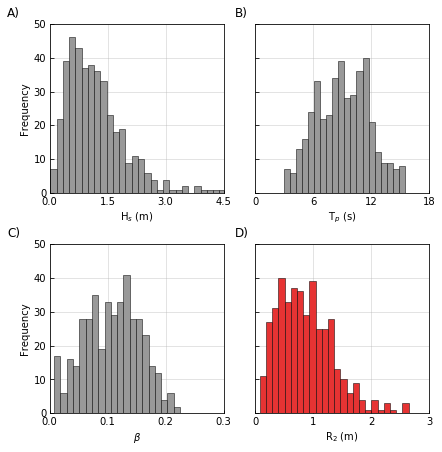

In [3]:
# This cell plots histograms of the data
# Initialize the figure and axes
fig, axes = plt.subplots(2,2,figsize=(6,6))
plt.tight_layout(w_pad=0.1, h_pad=3)
# Subplot (0,0): Hs
ax = axes[0,0]
ax.hist(df.Hs,28,color=(0.6,0.6,0.6),edgecolor='k',lw=0.5) # Plot histogram
ax.set_xlabel('H$_s$ (m)') # Format plot
ax.set_ylabel('Frequency')
ax.set_xticks((0,1.5,3,4.5))
ax.set_xlim((0,4.5))
ax.set_ylim((0,50))
ax.grid(lw=0.5,alpha=0.7)
ax.text(-1.1, 52, 'A)', fontsize=12)
ax.tick_params(direction='in')
ax.set_axisbelow(True)
# Subplot (0,1): Tp
ax = axes[0,1]
ax.hist(df.Tp,20,color=(0.6,0.6,0.6),edgecolor='k',lw=0.5) # Plot histogram
ax.set_xlabel('T$_p$ (s)') # Format plot
ax.set_xticks((0,6,12,18))
ax.set_xlim((0,18))
ax.set_ylim((0,50))
ax.set_yticklabels([])
ax.grid(lw=0.5,alpha=0.7)
ax.text(-2.1, 52, 'B)', fontsize=12)
ax.tick_params(direction='in')
ax.set_axisbelow(True)
# Subplot (1,0): beta
ax = axes[1,0]
ax.hist(df.beach_slope,20,color=(0.6,0.6,0.6),edgecolor='k',lw=0.5) # Plot histogram
ax.set_xlabel(r'$\beta$') # Format plot
ax.set_ylabel('Frequency')
ax.set_xticks((0,0.1,0.2,0.3))
ax.set_xlim((0,0.3))
ax.set_ylim((0,50))
ax.grid(lw=0.5,alpha=0.7)
ax.text(-0.073, 52, 'C)', fontsize=12)
ax.tick_params(direction='in')
ax.set_axisbelow(True)
# Subplot (1,1): R2
ax = axes[1,1]
ax.hist(df.runup,24,color=(0.9,0.2,0.2),edgecolor='k',lw=0.5) # Plot histogram
ax.set_xlabel('R$_2$ (m)') # Format plot
ax.set_xticks((0,1,2,3))
ax.set_xlim((0,3))
ax.set_ylim((0,50))
ax.set_yticklabels([])
ax.grid(lw=0.5,alpha=0.7)
ax.text(-0.35, 52, 'D)', fontsize=12)
ax.tick_params(direction='in')
ax.set_axisbelow(True);

## 3. Develop GP Runup Predictor <a class="anchor" id="bullet-2"></a>
In this section we will develop the GP runup predictor.

We standardize the data for use in the GP by removing the mean and scaling to unit variance. This does not really affect GP performance but improves computational efficiency (see sklearn documentation for more information).

A kernel must be specified to develop the GP. Many kernels were trialled in initial GP development. The final kernel is a combination of the RBF and WhiteKernel. See **Section 2.1** and **Section 2.2** of the manuscript for further discussion.

In [4]:
# Define features and response data
X = df.drop(columns=df.columns[-1]) # Drop the last column to retain input features (Hs, Tp, slope)
y = df[[df.columns[-1]]]            # The last column is the predictand (R2)

In [5]:
# Specify the kernel to use in the GP
kernel = RBF(0.1, (1e-2, 1e2)) + WhiteKernel(1,(1e-2,1e2))

In [6]:
# Train GP model on training dataset
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=9,
                              normalize_y=True,
                              random_state=123)
gp.fit(X, y);

## 4. Test GP Runup Predictor <a class="anchor" id="bullet-3"></a>
This section now shows how the GP runup predictor can be used to test 50 test samples not previosuly used in training.

In [7]:
# Read in .csv test data file as a pandas dataframe
df_test = pd.read_csv('../data_repo_temporary/lidar_runup_data_for_GP_testing.csv',index_col=0)
# Print the size and head of the dataframe
print('Data size:', df_test.shape)
df_test.head()

Data size: (50, 4)


,Hs,Tp,beach_slope,runup
idx,,,,
0,0.469651,6.558596,0.044777,0.131011
1,2.326858,10.628132,0.163988,1.274534
2,1.749609,8.606207,0.080803,0.742904
3,1.541179,8.635184,0.077809,0.544136
4,1.090123,7.570075,0.056100,0.590942


In [8]:
# Predict the data
X_test = df_test.drop(columns=df.columns[-1]) # Drop the last column to retain input features (Hs, Tp, slope)
y_test = df_test[[df_test.columns[-1]]]       # The last column is the predictand (R2)
y_test_predictions = gp.predict(X_test)
print('GP RMSE on test data =', format(np.sqrt(mean_squared_error(y_test,y_test_predictions)),'.2f'))

GP RMSE on test data = 0.22


GP RMSE on test data = 0.22
GP bias on test data = 0.07


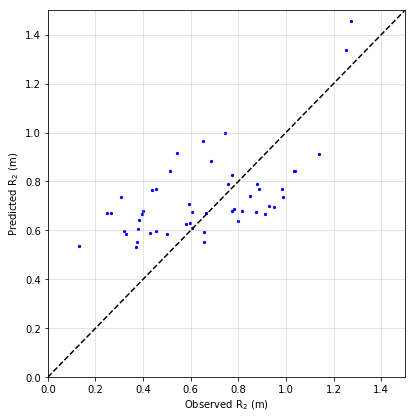

In [9]:
# This cell plots a figure comparing GP predictions to observations for the testing dataset
# Similar to Figure 4 in the manuscript
# Initialize the figure and axes
fig, axes = plt.subplots(figsize=(6,6))
plt.tight_layout(pad=2.2)
# Plot and format
axes.scatter(y_test,y_test_predictions,s=20,c='b',marker='.')
axes.plot([0,4],[0,4],'k--')
axes.set_ylabel('Predicted R$_2$ (m)')
axes.set_xlabel('Observed R$_2$ (m)')
axes.grid(lw=0.5,alpha=0.7)
axes.set_xlim(0,1.5)
axes.set_ylim(0,1.5)
# Print some statistics
print('GP RMSE on test data =', format(np.sqrt(mean_squared_error(y_test,y_test_predictions)),'.2f'))
print('GP bias on test data =', format(np.mean(y_test_predictions-y_test.values),'.2f'))

## 5. Explore GP Prediction Uncertainty <a class="anchor" id="bullet-3"></a>
This section explores how we can draw random samples from the GP to explain scatter in the runup predictions. We randomly draw 100 samples from the GP and calculate how much of the scatter in the runup predictions is captured by the ensemble envelope for different ensemble sizes. The process is repeated 100 times for robustness. See **Section 3.3** of the manuscript for further discussion.

We then plot the prediction with prediction uncertainty to help visualize.

In [10]:
# Draw 100 samples from the GP model using the testing dataset
GP_draws = gp.sample_y(X_test, n_samples=100, random_state=123).squeeze() # Draw 100 random samples from the GP
# Initialize result arrays
perc_ens = np.zeros((100,100)) # Initialize ensemble capture array
perc_err = np.zeros((100,))    # Initialise arbitray error array
# Loop to get results
for i in range(0,perc_ens.shape[0]):
    # Caclulate capture % in envelope created by adding arbitrary, uniform error to mean GP prediction
    lower = y_test_predictions*(1-i/100) # Lower bound
    upper = y_test_predictions*(1+i/100) # Upper bound
    perc_err[i] = sum((np.squeeze(y_test)>=np.squeeze(lower)) & (np.squeeze(y_test)<=np.squeeze(upper)))/y_test.shape[0] # Store percent capture
    for j in range(0,perc_ens.shape[1]):
        ind = np.random.randint(0,perc_ens.shape[0],i+1) # Determine i random integers
        lower = np.min(GP_draws[:,ind],axis=1) # Lower bound of ensemble of i random members
        upper = np.max(GP_draws[:,ind],axis=1) # Upper bound of ensemble of i random members
        perc_ens[i,j] = sum((np.squeeze(y_test)>=lower) & (np.squeeze(y_test)<=upper))/y_test.shape[0] # Store percent capture

# draws needed for 95% capture = 11
Mean/Min/Max for 11 draws = 95.0%/86.0%/100.0%
% added error needed for 95% capture = 59%


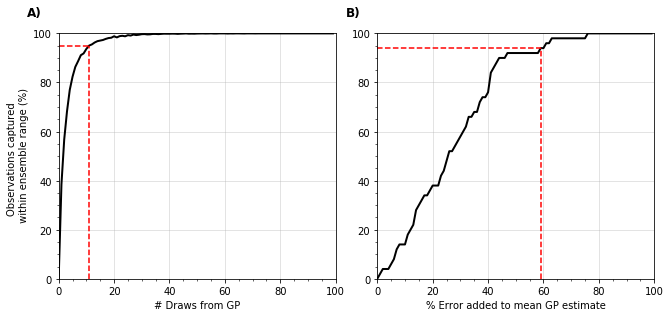

In [11]:
# This cell plots a figure showing how samples from the GP can help to capture uncertainty in predictions
# Similar to Figure 5 from the manuscript
# Initialize the figure and axes
fig, axes = plt.subplots(1,2,figsize=(9,4))
plt.tight_layout()
lim = 0.95 # Desired limit to test
# Plot ensemble results
ax = axes[0]
perc_ens_mean = np.mean(perc_ens,axis=1)
ax.plot(perc_ens_mean*100,'k-',lw=2)
ind = np.argmin(abs(perc_ens_mean-lim)) # Find where the capture rate > lim
ax.plot([ind,ind],[0,perc_ens_mean[ind]*100],'r--')
ax.plot([0,ind],[perc_ens_mean[ind]*100,perc_ens_mean[ind]*100],'r--')
ax.set_xlabel('# Draws from GP')
ax.set_ylabel('Observations captured \n within ensemble range (%)')
ax.grid(lw=0.5,alpha=0.7)
ax.minorticks_on()
ax.set_xlim(0,100);
ax.set_ylim(0,100);
ax.text(-11.5, 107, 'A)', fontweight='bold', fontsize=12)
print('# draws needed for ' + format(lim*100,'.0f') + '% capture = ' + str(ind))
print('Mean/Min/Max for ' + str(ind) + ' draws = '
      + format(np.mean(perc_ens[ind,:])*100,'.1f') + '%/'
      + format(np.min(perc_ens[ind,:])*100,'.1f') + '%/'
      + format(np.max(perc_ens[ind,:])*100,'.1f') + '%')
# Plot arbitrary error results
ax = axes[1]
ax.plot(perc_err*100,'k-',lw=2)
ind = np.argmin(abs(perc_err-lim))  # Find where the capture rate > lim
ax.plot([ind,ind],[0,perc_err[ind]*100],'r--')
ax.plot([0,ind],[perc_err[ind]*100,perc_err[ind]*100],'r--')
ax.set_xlabel('% Error added to mean GP estimate')
ax.grid(lw=0.5,alpha=0.7)
ax.minorticks_on()
ax.set_xlim(0,100);
ax.set_ylim(0,100);
ax.text(-11.5, 107, 'B)', fontweight='bold', fontsize=12)
print('% added error needed for ' + format(lim*100,'.0f') + '% capture = ' + str(ind) + '%')

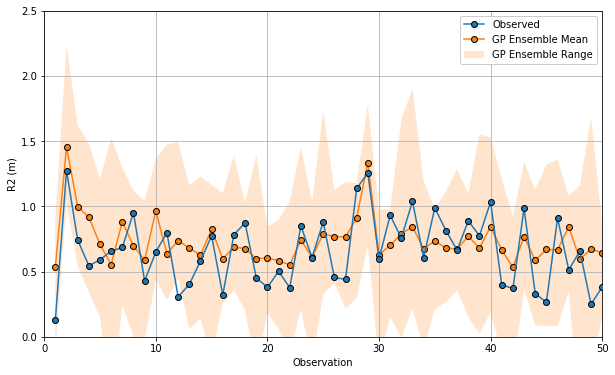

In [12]:
# This cell plots predictions for all 50 test samples with prediction uncertainty from 12 ensemble members.
# In the cell above, 12 members was identified as optimal for capturing 95% of observations.
# Initialize the figure and axes
fig, axes = plt.subplots(1,1,figsize=(10,6))
# Make some data for plotting
x = np.arange(1, len(y_test)+1)
lower = np.min(GP_draws[:,:12],axis=1) # Lower bound of ensemble of 12 random members
upper = np.max(GP_draws[:,:12],axis=1) # Upper bound of ensemble of 12 random members
# Plot
axes.plot(x,y_test,'o',linestyle='-',color='C0',mfc='C0',mec='k',zorder=10,label='Observed')
axes.plot(x,y_test_predictions,'k',marker='o',color='C1',mec='k',label='GP Ensemble Mean')

axes.fill_between(x,
                  lower,
                  upper,
                  alpha=0.2,
                  facecolor='C1',
                  label='GP Ensemble Range')
# Formatting
axes.set_xlim(0,50)
axes.set_ylim(0,2.5)
axes.set_xlabel('Observation')
axes.set_ylabel('R2 (m)')
axes.grid()
axes.legend(framealpha=1)